In [3]:
!pip install ptflops

  Using cached ptflops-0.7.3-py3-none-any.whl (18 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  

In [4]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import ptflops

from google.colab import drive
from PIL import Image
from matplotlib import cm

import xml.etree.ElementTree as ET

import json
import os

In [5]:
# Mount your Google Drive to Colab.
drive.mount('/content/gdrive')


#TODO: replace with current dataset location
root_file = '/content/gdrive/MyDrive/CS4782/project/food-101/images'
## END TODO

Mounted at /content/gdrive


# Data Pre-Processing

In [6]:
classes = os.listdir(root_file)[1:]
classes

['cheese_plate', 'club_sandwich', 'cup_cakes', 'apple_pie', 'tuna_tartare']

In [7]:
imgs = []
labels = []

counter = 0
class_to_label_map = {}
label_to_class_map = {}

for c_idx, c in enumerate(classes):
    if c not in class_to_label_map:
        class_to_label_map[counter] = c
        label_to_class_map[c] = counter
        counter += 1

print(class_to_label_map)


{0: 'cheese_plate', 1: 'club_sandwich', 2: 'cup_cakes', 3: 'apple_pie', 4: 'tuna_tartare'}


In [8]:
for i in classes:
    joined_path = os.path.join(root_file, i)
    image_file_names = os.listdir(joined_path)
    for idx, image_file_name in enumerate(image_file_names):
        root_path_to_img = os.path.join(joined_path, image_file_name)
        actual_images = Image.open(root_path_to_img)
        try:
            image = actual_images.resize((256,256)).convert("RGB")
            image = np.array(image)
            image = np.transpose(image, (2,0,1)) #3, 256, 256
            imgs.append(image) # list of images : tensors are stored in list
            labels.append(label_to_class_map[i])
        except:
            pass

In [9]:
from sklearn.model_selection import train_test_split

imgs = np.array(imgs) # array of images
labels = np.array(labels) # array of labels

X_train, X_test, y_train, y_test = train_test_split(imgs, labels, train_size=0.8, test_size=0.2)

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FoodDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = {
            'feature': torch.tensor(self.X[idx], dtype=torch.float),
            'label': torch.tensor(self.y[idx], dtype=torch.int)  # Change dtype if needed
        }
        return sample['feature'].to(device), sample['label'].to(device)

In [11]:
train_dataset = FoodDataset(X_train, y_train)
test_dataset = FoodDataset(X_test, y_test)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

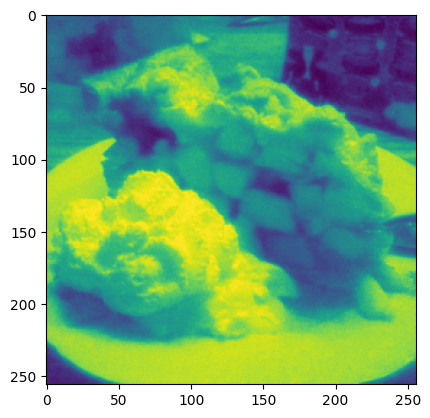

In [12]:
image, label = X_train[0], y_train[0]
to_pil = transforms.ToPILImage()
pil_image = to_pil(image[0])
plt.imshow(pil_image)
plt.show()

In [13]:
for batch_idx, (feature, label) in enumerate(train_loader):
    # Check the shape and type of the data
    print(f"Batch {batch_idx}:")
    print(f"Data - Shape: {feature.shape}, Type: {feature.dtype}")
    print(f"Target - Shape: {label.shape}, Type: {label.dtype}")
    if batch_idx > 2:
        break

Batch 0:
Data - Shape: torch.Size([32, 3, 256, 256]), Type: torch.float32
Target - Shape: torch.Size([32]), Type: torch.int32
Batch 1:
Data - Shape: torch.Size([32, 3, 256, 256]), Type: torch.float32
Target - Shape: torch.Size([32]), Type: torch.int32
Batch 2:
Data - Shape: torch.Size([32, 3, 256, 256]), Type: torch.float32
Target - Shape: torch.Size([32]), Type: torch.int32
Batch 3:
Data - Shape: torch.Size([32, 3, 256, 256]), Type: torch.float32
Target - Shape: torch.Size([32]), Type: torch.int32


## Mask Unit

In [14]:
class Gumbel(nn.Module):
    def __init__(self, eps=1e-8):
        super(Gumbel, self).__init__()
        self.eps = eps

    def forward(self, x):
        pi1 = pi2 = torch.rand_like(x, device = device)
        g1 = -torch.log(-torch.log(pi1 + self.eps) + self.eps)
        g2 = -torch.log(-torch.log(pi2 + self.eps) + self.eps)
        x = x + g1 - g2

        soft = torch.sigmoid(x)
        hard = ((soft >= 0.5).float() - soft).detach() + soft
        return hard


class MaskUnit(nn.Module):
    def __init__(self, channels, stride=1, dilate_stride=1):
        super(MaskUnit, self).__init__()
        self.channels = channels
        self.M = nn.Conv2d(channels, channels, stride=stride, kernel_size=1, padding=0, device=device)
        self.G = Gumbel()
        self.hard_decisions = None


    def dilate(self, x):
        kernel = torch.ones([self.channels, self.channels, 3, 3], device = device)

        x = F.conv2d(x, kernel, padding = 1, stride = 1)
        hard_decision = x >= 1
        return hard_decision * x

    def getHardDecisions(self):
        if self.hard_decisions == None:
            return 0
        return self.hard_decisions

    def forward(self, x):
        x = self.M(x)
        x = self.G(x)
        self.hard_decisions = x

        x = self.dilate(x)
        return x # Image of zeroed out unimportant pixels


In [15]:
class DownSample(nn.Module):
    def __init__(self, in_channel, out_channel, stride):
        super(DownSample, self).__init__()
        self.in_channel = in_channel
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride, bias=False, device=device)
        self.bn1 = nn.BatchNorm2d(out_channel, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=device)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        return x

## Dynamic Layer

In [16]:
class DynamicLayer(nn.Module):
    def __init__(self, in_channel, hidden_layer1, hidden_layer2, out_channel, norm_layer=None, stride=1, downsample=None):

        super(DynamicLayer, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.maskUnit = MaskUnit(in_channel)
        self.hard_decisions = self.maskUnit.getHardDecisions()

        self.conv1 = nn.Conv2d(in_channel, hidden_layer1, kernel_size=1, stride=1, padding=0, bias=False, device=device)
        self.bn1 = nn.BatchNorm2d(hidden_layer1, device=device)

        self.conv2 = nn.Conv2d(hidden_layer1, hidden_layer2, kernel_size=3, stride=(stride,stride), padding=1, bias=False, device=device)
        self.bn2 = nn.BatchNorm2d(hidden_layer2, device=device)

        self.conv3 = nn.Conv2d(hidden_layer2, out_channel, kernel_size=1, stride=1, padding=0, bias=False, device=device)
        self.bn3 = nn.BatchNorm2d(out_channel, device=device)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride


    def forward(self, x):
        identity = torch.clone(x).detach()
        x = self.maskUnit(x)

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x + self.hard_decisions)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            identity = self.downsample(identity)

        x += identity
        x = F.relu(x)

        return x

## Overall Architecture

In [17]:
# from torchvision.models import resnet50, ResNet50_Weights


# dynconv = resnet50().to(device)

# layer1 = dynconv.layer1
# layer2 = dynconv.layer2
# layer3 = dynconv.layer3
# layer4 = dynconv.layer4

# layer1[0] = DynamicLayer(64, 64, 64, 256, downsample=DownSample(64, 256, 1))
# layer1[1] = DynamicLayer(256, 64, 64, 256)
# layer1[2] = DynamicLayer(256, 64, 64, 256)

# layer2[0] = DynamicLayer(256, 128, 128, 512, stride=2, downsample=DownSample(256, 512, 2))
# layer2[1] = DynamicLayer(512, 128, 128, 512)
# layer2[2] = DynamicLayer(512, 128, 128, 512)
# layer2[3] = DynamicLayer(512, 128, 128, 512)

# layer3[0] = DynamicLayer(512, 256, 256, 1024, stride=2, downsample=DownSample(512, 1024, 2))
# layer3[1] = DynamicLayer(1024, 256, 256, 1024)
# layer3[2] = DynamicLayer(1024, 256, 256, 1024)
# layer3[3] = DynamicLayer(1024, 256, 256, 1024)
# layer3[4] = DynamicLayer(1024, 256, 256, 1024)
# layer3[5] = DynamicLayer(1024, 256, 256, 1024)

# layer4[0] = DynamicLayer(1024, 512, 512, 2048, stride=2, downsample=DownSample(1024, 2048, 2))
# layer4[1] = DynamicLayer(2048, 512, 512, 2048)
# layer4[2] = DynamicLayer(2048, 512, 512, 2048)


In [26]:
from torchvision.models import resnet50, ResNet50_Weights
class DynamicArchitecture(nn.Module):
    def __init__(self):
        super().__init__()
        self.dynconv = resnet50().to(device)

        layer1 = self.dynconv.layer1
        layer2 = self.dynconv.layer2
        layer3 = self.dynconv.layer3
        layer4 = self.dynconv.layer4

        layer1[0] = DynamicLayer(64, 64, 64, 256, downsample=DownSample(64, 256, 1))
        layer1[1] = DynamicLayer(256, 64, 64, 256)
        layer1[2] = DynamicLayer(256, 64, 64, 256)

        layer2[0] = DynamicLayer(256, 128, 128, 512, stride=2, downsample=DownSample(256, 512, 2))
        layer2[1] = DynamicLayer(512, 128, 128, 512)
        layer2[2] = DynamicLayer(512, 128, 128, 512)
        layer2[3] = DynamicLayer(512, 128, 128, 512)

        layer3[0] = DynamicLayer(512, 256, 256, 1024, stride=2, downsample=DownSample(512, 1024, 2))
        layer3[1] = DynamicLayer(1024, 256, 256, 1024)
        layer3[2] = DynamicLayer(1024, 256, 256, 1024)
        layer3[3] = DynamicLayer(1024, 256, 256, 1024)
        layer3[4] = DynamicLayer(1024, 256, 256, 1024)
        layer3[5] = DynamicLayer(1024, 256, 256, 1024)

        layer4[0] = DynamicLayer(1024, 512, 512, 2048, stride=2, downsample=DownSample(1024, 2048, 2))
        layer4[1] = DynamicLayer(2048, 512, 512, 2048)
        layer4[2] = DynamicLayer(2048, 512, 512, 2048)
        self.fc1 = nn.Linear(1000, 6).to(device)

    def forward(self, x):
        x = self.dynconv(x).to(device)
        x = F.sigmoid(x).to(device)
        x = self.fc1(x).to(device)
        return x

# Training Functions

In [27]:
def val(model, val_data_loader, criterion):
    model.eval()
    val_running_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.to(torch.long))
            val_running_loss += loss.item()
            predictions = outputs.argmax(dim=1, keepdim=True)
            total_correct += predictions.eq(labels.view_as(predictions)).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples

    return val_running_loss / len(val_data_loader), accuracy

In [28]:
import copy

def train(model, data_loader, val_data_loader, criterion, optimizer, epochs):
    """
    Inputs:
    model (torch.nn.Module): The deep learning model to be trained.
    data_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    val_data_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
    criterion (torch.nn.Module): Loss function to compute the training loss.
    optimizer (torch.optim.Optimizer): Optimizer used for updating the model parameters.
    epochs (int): Number of training epochs.

    Outputs:
    Tuple of (train_loss_arr, val_loss_arr), an array of the training and validation
    losses at each epoch
    """
    train_loss_arr = []
    val_loss_arr = []
    pred_arr = []
    running_loss = 0.0
    count = 0

    model = model.to(device)

    for epoch in range(epochs):
        running_loss = 0.0
        num_correct = 0.0
        count = 0
        for batch_idx, (train_features, train_labels) in enumerate(data_loader):
            # train_features = data['feature']
            # train_labels = data['label']
            count += 1

            # if count >= 15:
            #     break

            optimizer.zero_grad()
            assert (type(train_features) != str)
            train_features, train_labels = train_features.to(device), train_labels.to(device)
            preds = model(train_features) # saving all of our features
            train_loss = criterion(preds, train_labels.to(torch.long))

            train_loss.backward()

            running_loss += train_loss.item()

            optimizer.step()
            print('Current Loss at batch {}:'.format(batch_idx), str(running_loss))

        train_loss = running_loss / len(data_loader)
        train_loss_arr.append(train_loss)
        print("Current Loss at Epoch {}: ".format(epoch) + str(running_loss))

        model = model.to(device)

        val_loss, accuracy = val(model, val_data_loader, criterion)
        print("val_loss", val_loss)
        print("accuracy", accuracy)
        val_loss_arr.append(val_loss)
        pred_arr.append(accuracy)


    print('Training finished.')
    return train_loss_arr, val_loss_arr, pred_arr

In [ ]:
#train DynvNet
criterion = nn.CrossEntropyLoss()
# one-hot encode the output before putting it into the cross entropy loss
dynconv = DynamicArchitecture().to(device)
optimizer = optim.Adam(dynconv.parameters(), lr=2e-4)
# optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 10
with torch.cuda.device(0):
    net = dynconv
    macs, params = ptflops.get_model_complexity_info(net, (3, 175, 200), as_strings=True, backend='pytorch', print_per_layer_stat=True, verbose=True)
    print('{:<30}  {:<8}'.format('Computational complexity: ', str(macs)))
    print('{:<30}  {:<8}'.format('Number of parameters: ', str(params)))
convnet_train_loss, convnet_val_loss, convnet_val_acc = train(dynconv, train_loader, test_loader, criterion, optimizer, epochs)

DynamicArchitecture(
  41.51 M, 100.000% Params, 5.31 GMac, 99.859% MACs, 
  (dynconv): ResNet(
    41.5 M, 99.986% Params, 5.31 GMac, 99.859% MACs, 
    (conv1): Conv2d(9.41 k, 0.023% Params, 82.79 MMac, 1.556% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(128, 0.000% Params, 1.13 MMac, 0.021% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(0, 0.000% Params, 563.2 KMac, 0.011% MACs, inplace=True)
    (maxpool): MaxPool2d(0, 0.000% Params, 563.2 KMac, 0.011% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      351.55 k, 0.847% Params, 773.41 MMac, 14.540% MACs, 
      (0): DynamicLayer(
        79.17 k, 0.191% Params, 174.17 MMac, 3.274% MACs, 
        (maskUnit): MaskUnit(
          4.16 k, 0.010% Params, 9.15 MMac, 0.172% MACs, 
          (M): Conv2d(4.16 k, 0.010% Params, 9.15 MMac, 0.172% MACs, 64, 64, kernel_size=(1, 1), stride=(1, 1))
 

In [ ]:
convnet_val_acc

In [25]:
resnet = resnet50()
resnet

NameError: name 'resnet50' is not defined

In [ ]:
class ResnetArchitecture(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet50()
        self.fc1 = nn.Linear(1000, 6)
    def forward(self, x):
        x = self.resnet(x)
        x = F.sigmoid(x)
        x = self.fc1(x)
        return x

In [ ]:
#train ResNet
criterion = nn.CrossEntropyLoss()
# one-hot encode the output before putting it into the cross entropy loss
model = ResnetArchitecture().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
# optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 10
with torch.cuda.device(0):
    net = model
    macs, params = ptflops.get_model_complexity_info(net, (3, 256, 256), as_strings=True, backend='pytorch', print_per_layer_stat=True, verbose=True)
    print('{:<30}  {:<8}'.format('Computational complexity: ', str(macs)))
    print('{:<30}  {:<8}'.format('Number of parameters: ', str(params)))
resnet_train_loss, resnet_val_loss, resnet_val_acc = train(model, train_loader, test_loader, criterion, optimizer, epochs)

In [ ]:
resnet_train_loss

In [ ]:
resnet_val_loss

In [ ]:
resnet_val_acc

In [ ]:
x = [epoch+1 for epoch in range(epochs)]

# Plot both lines on the same plot
plt.plot(x, convnet_train_loss, color='green', label='ConvNet Train Loss')
plt.plot(x, resnet_train_loss, color='blue', label='ResNet Train Loss')

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train Loss Comparison")
plt.legend()

# Show the plot
plt.show()

In [ ]:
x = [epoch+1 for epoch in range(epochs)]

# Plot both lines on the same plot
plt.plot(x, convnet_val_acc, color='green', label='ConvNet Validation Accuracy')
plt.plot(x, resnet_val_acc, color='blue', label='ResNet Validation Accuracy')

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.legend()

# Show the plot
plt.show()

In [ ]:
x = [epoch+1 for epoch in range(epochs)]

# Plot both lines on the same plot
plt.plot(x, convnet_val_loss, color='green', label='ConvNet Val Loss')
plt.plot(x, resnet_val_loss, color='blue', label='ResNet Val Loss')

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Val Loss Comparison")
plt.legend()

# Show the plot
plt.show()